In [1]:
from jupyter_addons import *
set_css()

# Network Flow Analysis with PyFlow API

The flow analysis is based on the method of Hardy Cross.<br>
<br>
In this notebook a drinking water installation in a apartment building will be analysed. A scheme of the piping network can be found [here](../resources/ex1_scheme.pdf). The building has nine floors. Apartments are on the first up to the eighth floor. On each floor there are three apartments, except on the eighth floor there is only one apartment.<br> 
<br>
Drinking water runs to the apartments through a single riser in the building having a nominal diameter (DN) of 40 mm, which corresponds with an inside diameter of 40.9 mm (pipe schedule 40). At the ground floor a booster pump is provided.<br>
<br>
The individual drinking water installations in the apartments will be modeled by a single **equivalent valve at floor level**. The peak flow rates in the sections of the riser were estimated using the norm DIN 1988-300 (2012). The total peak flow rate at the entrance of the building is estimated to be 1.696 L/s. If this value is divided equally across each floor of the building, the flow rate at floor level equals 0.212 L/s. Assuming that this flow rate is accomplished with a feed pressure of 3 bar, a resistance coefficient of the equivalent valve can be derived, which will be based on a nominal diameter (DN) of 40 mm.<br>
<br>
**The purpose of the analysis is to find the flow rates in the pipe sections of the riser, the flow rates through the valves on each floor, the feed pressure at each floor in the riser and the working point of the booster pump, assuming that the feed pressure in the public water distribution network equals 2 bar.**

## 1. Calculate the Resistance Coefficient of the Equivalent Floor Valve

When the flow rate through a piping element and the pressure drop across it are known, we can calculate the flow coefficient *K<sub>v</sub>* of this piping element. This flow coefficient can then also be converted  to a resistance coefficient *zeta* (ζ). In order to make the conversion from a flow to a resistance coefficient a reference diameter is needed, because a resistance coefficient is related to flow velocity. We refer to the nominal diameter of the riser to express the resistance coefficient of the equivalent valve.

**Input:**

In [2]:
import quantities as qty
from pypeflow.core.flow_coefficient import FlowCoefficient
from pypeflow.core.resistance_coefficient import ResistanceCoefficient
from pypeflow.core.pipe_schedules import PipeSchedule40

In [3]:
# flow rate at floor level
V_floor = qty.VolumeFlowRate(0.212, 'L/s')

# feed pressure at floor level
dp = qty.Pressure(3.0, 'bar')

# reference inside diameter for the resistance coefficient 
di = PipeSchedule40.inside_diameter(DN=qty.Length(40, 'mm'))

**Calculations:**

In [4]:
# flow coefficient of the equivalent valve
Kv = FlowCoefficient.calc_Kv(V_floor, dp)

# resistance coefficient of the equivalent valve
zeta = ResistanceCoefficient.from_Kv(Kv, di)

**Solution:**

In [5]:
display_item(f'Resistance coefficient <em>zeta</em> of the equivalent valve at floor level = <b>{zeta:.3f}</b>')

## 2. Setting up the Analysis

To perform the network flow analysis we need the class `Analyzer`: 

In [6]:
from pypeflow.analysis import Analyzer

### 2.1 Specify the measuring units

The first step to take in setting up the analysis, involves the specification of the measuring units in which the quantities will be expressed. The following quantities are used:
- the length of a pipe section or the height between two floors
- the diameter of a pipe's circular cross section
- pressure and pressure differences
- flow rates in pipe sections
- flow velocities in pipe sections

In [7]:
Analyzer.set_units({
    'length': 'm',
    'diameter': 'mm',
    'flow_rate': 'L/s',
    'pressure': 'bar',
    'velocity': 'm/s'
})

### 2.2 Create the Network Object

In the next step we pass the necessary data to the `Analyzer` in order to create the network:

- A network is composed of nodes that are interconnected by pipe sections. A network has a start and an end node.
- The fluid that flows in the piping network must be specified. Here it is water at a temperature of 10 °C.
- The pipe schedule of the pipe sections in the network must be specified. The pipe schedule determines the commercial available dimensions of the pipe's cross section and the pipe wall roughness. Here we use ANSI pipe schedule 40.

In [8]:
Analyzer.create_network(
    start_node_id='n1',
    end_node_id='n0',
    fluid='water',
    fluid_temperature=10.0,
    pipe_schedule='pipe_schedule_40'
)

## 3. Configuring the Piping Network

**The configuration of a piping network is specified in tabular format in a seperate *.csv*-file**. From the configuration data in this file the `Analyzer` is able to construct the `Network` object.<br>
<br>
The next table shows the network's configuration data, read from the *.csv*-file called "config4_hardy.csv", that was made using a spreadsheet program. 

In [9]:
import pandas as pd
config = pd.read_csv('../projects/config4_hardy.csv')
display_table(config)

,loop id,section id,start node id,end node id,diameter,length,zeta,a0,a1,a2,dp fixed,flow rate
0,l1,s12,n1,n2,40.0,16.7,6.646,585000.0,-58700000.0,-4.600000e+10,NaN,1.696
1,l1,s22*,n2,n2*,40.0,0.1,23064.414,NaN,NaN,NaN,NaN,0.212
2,l1,s2*0,n2*,n0,NaN,NaN,NaN,NaN,NaN,NaN,0.432,NaN
3,l1,s10,n0,n1,NaN,NaN,NaN,NaN,NaN,NaN,-2.000,NaN
4,l2,s23,n2,n3,40.0,2.7,-0.029,NaN,NaN,NaN,NaN,1.484
5,l2,s33*,n3,n3*,40.0,0.1,23064.414,NaN,NaN,NaN,NaN,0.212
6,l2,s3*2*,n3*,n2*,NaN,NaN,NaN,NaN,NaN,NaN,0.265,NaN
7,l2,s22*,n2,n2*,40.0,0.1,23064.414,NaN,NaN,NaN,NaN,-0.212
8,l3,s34,n3,n4,40.0,2.7,-0.037,NaN,NaN,NaN,NaN,1.272
9,l3,s44*,n4,n4*,40.0,0.1,23064.414,NaN,NaN,NaN,NaN,0.212


As already mentioned, the network flow analysis uses the **Hardy Cross method** to solve for the flow rates and pressures in the network.<br> 
<br>
The Hardy Cross method divides the network in primary loops to solve the network problem. A section in a primary loop can belong to at most two loops. The primary loops must be identified by the user in the configuration file. The table is written down loop by loop. A row in the table corresponds with a pipe section in the network. A section that belongs to two different loops must be entered twice, i.e. for each loop in which the section is present.<br>

- In the 1st column `loop id` the id of the loop a pipe section belongs to is entered. 
- In the 2nd column `section id` the id of the pipe section is entered.
- In the 3th column `start node id` the id of the start node of the pipe section is entered. This is the node where the flow in the section is supposed to leave. 
- In the 4th column `end node id` the id of the end node of the section is entered. This is the node where the flow in the section is supposed to arrive.

With this information the `Analyzer` is able to find out how pipe sections are interconnected in the network. Looking at the [scheme](../resources/ex1_scheme.pdf) one can understand how the network's configuration is built.<br>

In the following columns the data about the pipe sections that are needed for calculating the pressure drops in the network, are entered:

- In the 5th column `diameter` the nominal diameter of the pipe section is entered according to the measuring unit for diameter that was specified when setting up the analysis.
- In the 6th column `length` the length of the pipe section is entered according to the measuring unit for length that was specified when setting up the analysis.
- In the 7th column `zeta` the sum of the resistance coefficients of fittings/valves in the pipe section are entered.
- In the 8th up to and including the 10th column the coefficients that describe the pump curve are entered. The pump curve is fitted by a second order polynomial:
$$\Delta {p_P} = {a_0} + {a_1}V + {a_2}{V^2}$$ 
The pump curve coefficients can be derived by curve fitting from the pump's data sheet. The class `PumpCurve` in the module *pyflow.utils.pump_curve* can be used for this purpose.
- The 11th column `dp fixed` applies only to so called *pseudo* sections. A pseudo section connects two nodes that have fixed energy (expressed in terms of pressure) and which are not connected by any real pipe section. So there is no fluid flow in a pseudo section. In our example there are pseudo connections that connect the exit nodes of the valves at the different floor levels. The pressure difference between these nodes is fixed and equal to the height difference between the floors expressed in terms of pressure (aka. elevation head). The pressure difference is entered according to the measuring unit for pressure that was specified when setting up the analysis.
- In the 12th column `flow rate` an initial guess for the flow rate in each pipe or pump section is entered, according to the measuring unit for flow rate that was specified when setting up the analysis. Take care that while entering initial guesses for the flow rates in pipe sections, the law of conservation of mass at the nodes must be respected (*what goes in, must come out*).

Flow rates and pressure drops carry a sign. This sign (plus or minus sign) is determined by the reference loop sense, which generally is always taken as being clockwise. If a flow rate in a pipe section has a flow sense that opposes the reference loop sense, it is given a minus sign. The sign of a pressure difference in a pseudo section is determined by the flow sense the pressure difference would cause with respect to the reference loop sense.

In [10]:
Analyzer.configure_network('../projects/config4_hardy.csv')

In the table above one sees that in pseudo section *s10* a negative pressure difference of -2.0 bar has been entered. This is the feed pressure from the public distribution network at the entrance of the analyzed network. In section *s12* there is the booster pump. It must be mentioned that the pump curve coefficients need to be based on a flow rate value expressed in m<sup>3</sup>/s and a pressure value expressed in Pa.

## 4. Solving the Piping Network

The Hardy Cross method works by iteration, starting with the initial guesses entered by the user. The maximum number of iterations can be specified. If no solution is found within the maximum number of iterations an error will be raised. One can set the maximum number of iterations to a bigger number, should an error be raised. The stop criterion for iterating is the allowable error for the loop pressure drop. Ideally the sum of the pressure drops across each loop in the network should be exactly zero according to the law of conservation of energy. The error value specified is the allowable deviation from zero at which the `Analyzer` will quit iterating and returns the solution.

In [11]:
Analyzer.solve(error=1.0e-3, i_max=5000)

**Result:**

In [12]:
solution = Analyzer.get_network()
display_table(solution)

,loop_id,section_id,start_node_id,end_node_id,length [m],diameter [mm],zeta,flow_rate [L/s],velocity [m/s],pressure_drop [bar]
0,l1,s12,n1,n2,16.7,40.0,6.646,1.857,1.413,-3.008
1,l1,s22*,n2,n2*,0.1,40.0,23064.414,0.262,0.199,4.576
2,l1,s2*0,n2*,n0,NaN,NaN,NaN,NaN,NaN,0.432
3,l1,s10,n0,n1,NaN,NaN,NaN,NaN,NaN,-2.000
4,l2,s23,n2,n3,2.7,40.0,-0.029,1.595,1.214,0.012
5,l2,s33*,n3,n3*,0.1,40.0,23064.414,0.254,0.193,4.299
6,l2,s3*2*,n3*,n2*,NaN,NaN,NaN,NaN,NaN,0.265
7,l2,s22*,n2,n2*,0.1,40.0,23064.414,-0.262,-0.199,-4.576
8,l3,s34,n3,n4,2.7,40.0,-0.037,1.341,1.021,0.009
9,l3,s44*,n4,n4*,0.1,40.0,23064.414,0.245,0.187,4.025


From the table, looking at section *s12*, we can see how much water is flowing to the riser and through the booster pump. Knowing the pump curve, we can now also find the working point of the pump on the curve.

## 5. Finding the Working Point of the Booster Pump

**Get the flow rate through the booster pump**<br>
This is also the flow rate of the network, i.e. the flow rate entering the network.

In [13]:
V_pump = Analyzer.network.flow_rate('L/s')

display_item(f'Flow rate through booster pump in pipe section <em>s12</em> = <b>{V_pump:.3f}</b> L/s')

**Finding the pump curve coefficients from the pump's data sheet**<br>
From the pump curve in the data sheet it is read that:
- at zero flow the pump head is 60.0 m, 
- at 2.4 m<sup>3</sup>/h it is 52.0 m, 
- at 4.2 m<sup>3</sup>/h it is 48.0 m and 
- at 6.0 m<sup>3</sup>/h it is 36.0 m.

In the following code blocks the pump head at the calculated flow rate in section *s12* is calculated:

In [14]:
from pypeflow.utils.pump_curve import PumpCurve

# create PumpCurve object, set the desired units for flow rate and pressure 
pump_curve = PumpCurve(dest_units={'flow_rate': 'L/s', 'pressure': 'bar'})

# enter the measured points from the curve in the data sheet
pump_curve.add_measuring_points(
    points=[(0.0, 60.0), (2.4, 52.0), (4.2, 48.0), (6.0, 36.0)],
    units={'flow_rate': 'm^3/h', 'pressure': 'm'}
)

# get the pump coefficients, set the units for flow rate and pressure in which the 
# coefficients need to be expressed
a = pump_curve.get_coefficients({'flow_rate': 'L/s', 'pressure': 'bar'})

display_item(f'Pump curve coefficients = <b>{a}</b> refering to units of flow rate "L/s" and units of pressure "bar"')

**Calculating pump head.**<br>
Now that we know the pump coefficients, we can calculate the pump head:

In [15]:
p_pump = a[0] + a[1] * V_pump + a[2] * V_pump ** 2

display_item(f'Pump head at flow rate {V_pump:.3f} L/s = <b>{p_pump:.3f}</b> bar')

## 6. Getting the Flow Rates and Feed Pressures at Floor Level

From the solution table we can extract all the pipe sections with the equivalent valve. As the water flowing through the equivalent valves exits in open atmosphere (0 bar), the pressure drop across the floor sections is also equal to the feed pressure in the riser at the floor section's entrance.

In [16]:
df_floors = solution.iloc[[r for r in range(1,32,4)], :]
display_table(df_floors)

,loop_id,section_id,start_node_id,end_node_id,length [m],diameter [mm],zeta,flow_rate [L/s],velocity [m/s],pressure_drop [bar]
1,l1,s22*,n2,n2*,0.1,40.0,23064.414,0.262,0.199,4.576
5,l2,s33*,n3,n3*,0.1,40.0,23064.414,0.254,0.193,4.299
9,l3,s44*,n4,n4*,0.1,40.0,23064.414,0.245,0.187,4.025
13,l4,s55*,n5,n5*,0.1,40.0,23064.414,0.237,0.180,3.754
17,l5,s66*,n6,n6*,0.1,40.0,23064.414,0.228,0.174,3.486
21,l6,s77*,n7,n7*,0.1,40.0,23064.414,0.220,0.167,3.219
25,l7,s88*,n8,n8*,0.1,40.0,23064.414,0.210,0.160,2.952
29,l8,s99*,n9,n9*,0.1,40.0,23064.414,0.201,0.153,2.687


## 7. Looking at the Flow Paths

From the [scheme](../resources/ex1_scheme.pdf) it can be seen that there are eight different flow paths in the network. As each path starts in the same node *n1* and terminates in a node where the pressure equals the same atmospheric pressure, the static head of each path, i.e. the pressure difference between end node and start node must, be the same.<br>
<br>
The energy equation along any path in terms of pressure is expressed as:

$$
\left( {{p_1} + \rho \frac{{v_1^2}}{2} + \rho g{z_1}} \right) + \Delta {p_P} - \Delta {p_L} = \left( {{p_2} + \rho \frac{{v_2^2}}{2} + \rho g{z_2}} \right)
$$
with:
- ${p_1}$ = static pressure at start node
- ${\rho \frac{{v_1^2}}{2}}$ = velocity pressure at start node
- ${\rho g{z_1}}$ = elevation pressure at start node
- ${\Delta {p_P}}$ = pump energy added along path
- ${\Delta {p_L}}$ = pressure loss along path

The energy equation states that the total energy (expressed in terms of pressure) at the end node of the path equals the total energy at the start node plus any energy added by pumps along the path and minus the energy that gets lost due to flow along the path.<br>
<br>
The energy equation can also be rewritten as:

$$
\left( {{p_2} - {p_1}} \right) + \frac{\rho }{2}\left( {v_2^2 - v_1^2} \right) + \rho g\left( {{z_2} - {z_1}} \right) + \left( {\Delta {p_L} - \Delta {p_P}} \right) = 0
$$
with:
- ${{p_2} - {p_1}}$ = static head
- ${\frac{\rho }{2}\left( {v_2^2 - v_1^2} \right)}$ = velocity head
- ${\rho g\left( {{z_2} - {z_1}} \right)}$ = elevation head
- ${\left( {\Delta {p_L} - \Delta {p_P}} \right)}$ = dynamic head

The following table shows the velocity head, elevation head, dynamic head and static head of each path. One could check that along each path the sum of the different heads equals zero, as the law of energy demands.

In [17]:
df_paths = Analyzer.get_paths()
display_table(df_paths)

,path,"dp,vel [bar]","dp,elev [bar]","dp,dyn [bar]","dp,stat [bar]"
0,s12|s22*|s2*0,-0.01,0.432,1.568,-1.99
1,s12|s23|s33*|s3*2*|s2*0,-0.01,0.697,1.303,-1.99
2,s12|s23|s34|s44*|s4*3*|s3*2*|s2*0,-0.01,0.962,1.038,-1.99
3,s12|s23|s34|s45|s55*|s5*4*|s4*3*|s3*2*|s2*0,-0.01,1.227,0.773,-1.99
4,s12|s23|s34|s45|s56|s66*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,-0.01,1.492,0.508,-1.99
5,s12|s23|s34|s45|s56|s67|s77*|s7*6*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,-0.01,1.757,0.243,-1.99
6,s12|s23|s34|s45|s56|s67|s78|s88*|s8*7*|s7*6*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,-0.01,2.022,-0.022,-1.99
7,s12|s23|s34|s45|s56|s67|s78|s89|s99*|s9*8*|s8*7*|s7*6*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,-0.01,2.287,-0.287,-1.99


It should be noted that the pump head $\Delta {p_P}$ is also included in the dynamic head. In order to retrieve only the dynamic head loss $\Delta {p_L}$, the pump head should be added to the dynamic head. The dynamic head loss is related to flow rate. The relation between dynamic head loss and flow rate can be expressed as:

$$
\Delta {p_L} = R \cdot {V^2}
$$
with $R$ being the hydraulic resistance along the path under consideration.
The energy equation now becomes:

$$
\left( {{p_2} - {p_1}} \right) + \frac{\rho }{2}\left( {v_2^2 - v_1^2} \right) + \rho g\left( {{z_2} - {z_1}} \right) + R{V^2} = \Delta {p_P}
$$

The left side of the equation can be represented by the system curve, load curve or path curve. The right side of the equation can be represented by the pump curve. The equality sign means that the working point of the pump lies on the intersection of the system curve and the pump curve.

### 7.1 Drawing the Flow Path Curves and Pump Curve

In order to draw the path curves, we first need to determine the hydraulic resistance of each path. As noted above the pump head should first be added to the dynamic head of each path (they all have the same pump in common) in order to get the dynamic head loss of each path. The pump head has already been determined in the section about the working point of the booster pump. We also put the static head and elevation head of each path in a list.

**Creating flow path curves**

In [18]:
path_id_list = []; R_list = []; dp_stat_list = []; dp_elev_list = []

for path in Analyzer.network.paths:
    
    path_id_list.append(repr(path))
    
    # get dynamic head of each path in units bar
    dp_dyn = path.dynamic_head('bar')
    
    # add the pump head (expressed in bar) to the dynamic head of each path
    dp_dyn += p_pump
    
    # calculate hydraulic resistance of each path and put in a list
    R = dp_dyn / V_pump ** 2
    R_list.append(R)
    
    # get static head of each path and put it in a list
    dp_stat_list.append(path.static_head)
    
    # get elevation head of each path and put it in a list
    dp_elev_list.append(path.elevation_head)

Now a `SystemCurve` object can be created for each path, passing it the hydraulic resistance, the static head and elevation head of the path. Once this is done, a series of coordinates (kept in the variable `axes`) is calculated between an initial and final flow rate. For each path the series of coordinates are kept in a list `path_curves`.

In [19]:
from pypeflow.utils.system_curve import SystemCurve

path_curves = []
for i in range(len(path_id_list)):
    
    curve = SystemCurve(
        R_hyd=R_list[i],
        src_units={'flow_rate': 'L/s', 'pressure': 'bar'},
        dest_units={'flow_rate': 'L/s', 'pressure': 'bar'},
    )
    
    curve.set_static_head(dp_stat_list[i])
    curve.set_elevation_head(dp_elev_list[i])
    
    axes = curve.create_system_curve(
        V_initial=qty.VolumeFlowRate(0.0, 'L/s'),
        V_final=qty.VolumeFlowRate(2.5, 'L/s')
    )
    
    path_curves.append(axes)

**Creating the pump curve**

Next, the coordinates of the pump curve are calculated: 

In [20]:
axes_pump = pump_curve.create_pump_curve(
    V_initial=qty.VolumeFlowRate(0.0, 'L/s'),
    V_final=qty.VolumeFlowRate(2.5, 'L/s')
)

**Drawing the path and pump curves**

Finally, the path curves and pump curve can be drawn:

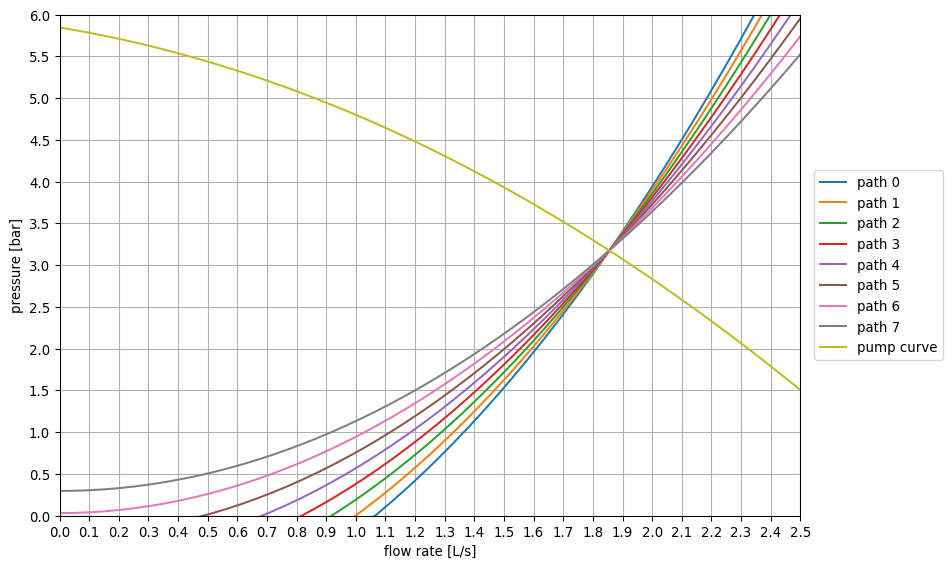

In [21]:
from nummath.graphing2 import LineGraph

graph = LineGraph(fig_size=(10, 6), dpi=96)

# path curves
for i in range(len(path_id_list)):
    graph.add_dataset(
        name=f'path {i}',
        x1_data=path_curves[i][0],
        y1_data=path_curves[i][1]
    )

# pump curve
graph.add_dataset(
    name='pump curve',
    x1_data=axes_pump[0],
    y1_data=axes_pump[1]
)

graph.x1.set_title('flow rate [L/s]')
graph.y1.set_title('pressure [bar]')
graph.x1.scale(lim_down=0.0, lim_up=2.5, step_size=0.1)
graph.y1.scale(lim_down=0.0, lim_up=6.0, step_size=0.5)
graph.add_legend()
graph.show()

From the diagram we can see that each path has a different path curve but they all intersect the pump curve in exactly the same point. This must be the case, as the pump can deliver only one flow rate and produce only one pump head at a certain time for all flow paths in the network.